In [19]:
from data_utils import load_data, notnan_indices, downsample_signal, moving_average

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [15]:
data_dir = "./data"
virgo_file = "VIRGO_Level1.txt"
results_dir = os.path.join(data_dir, "analysis")

data = load_data(os.path.join(data_dir, virgo_file))

t = data["timestamp"]  # Time in mission days
# t = data["timestamp"].apply(mission_day_to_year)  # Uncomment for time measured in years
pmo_a = data["pmo6v_a"]
pmo_b = data["pmo6v_b"]
temp = data["temperature"]
data.sample(15, random_state=2)

,timestamp,pmo6v_a,pmo6v_b,temperature
916133,707.2037,1364.124,NaN,27.612
4540366,3224.0322,1360.755,NaN,29.833
1184820,893.7919,1363.791,NaN,26.496
1652927,1218.8662,1363.623,NaN,26.422
6541184,4613.4893,NaN,NaN,29.463
6169960,4355.6948,1360.001,NaN,31.748
9447604,6631.8364,1359.868,NaN,29.349
10494042,7358.5293,1359.368,NaN,29.713
11214199,7858.6382,1358.931,NaN,27.109
7101944,5002.9058,1359.604,NaN,28.829


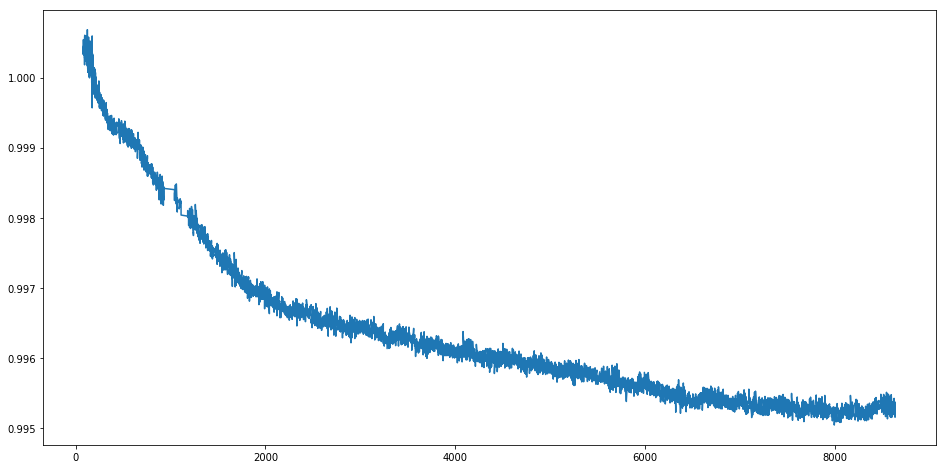

In [17]:
data_nn = data[["timestamp", "pmo6v_a", "pmo6v_b"]].dropna()
t_nn = data_nn["timestamp"]
x_a_nn = data_nn["pmo6v_a"]
x_b_nn = data_nn["pmo6v_b"]
ratio_a_b = x_a_nn/x_b_nn

plt.figure(5, figsize=(16, 8))
plt.plot(t_nn, ratio_a_b)
plt.savefig(os.path.join(results_dir, "ratio_a_b_raw.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

In [22]:
def exponential_decay(t, a, b, t0):
    return a + np.exp(b*(t-t0))

In [28]:
ratio_a_b.dtype

dtype('float64')

In [23]:
curve_fit(exponential_decay,  t_nn,  ratio_a_b)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:753: RuntimeWarning: overflow encountered in square
  cost = np.sum(infodict['fvec'] ** 2)
/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([1., 1., 1.]), array([[inf, inf, inf],
        [inf, inf, inf],
        [inf, inf, inf]]))

In [10]:
xa = np.array([1, 2, 3, np.nan, 4])
np.cumsum(xa)

array([ 1.,  3.,  6., nan, nan])

In [11]:
xa = np.nan_to_num(xa)
print(xa)
np.cumsum(xa)

[1. 2. 3. 0. 4.]


array([ 1.,  3.,  6.,  6., 10.])

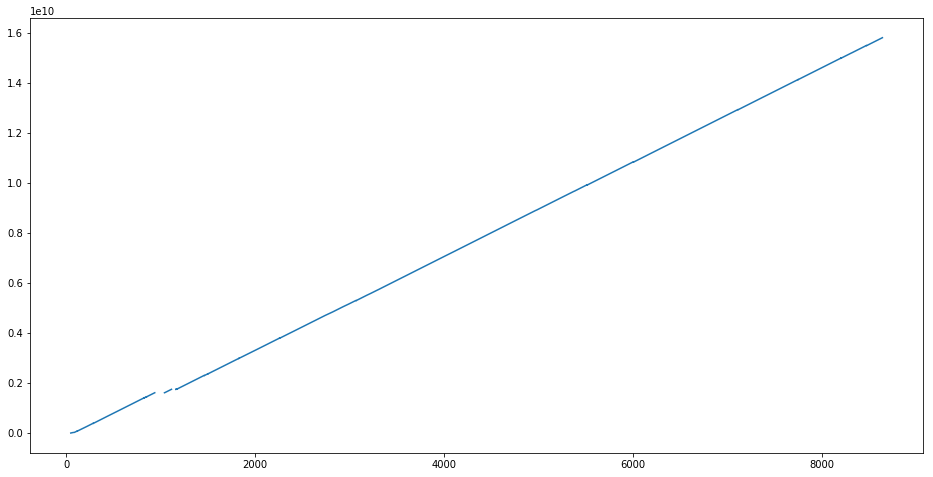

In [13]:
e_a = np.cumsum(np.nan_to_num(pmo_a.values))
data["e_a"] = e_a

plt.figure(5, figsize=(16, 8))
plt.plot(t, e_a)
plt.savefig(os.path.join(results_dir, "e_a.pdf"), bbox_inches="tight", quality=100, dpi=200)
plt.show()

